In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
import sklearn as sk
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import pandas as pd

In [5]:
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = datasets.MNIST(
    root='./data', train=True, transform=transform, download=True)

train_size = int(0.8 * len(mnist_dataset))
val_size = len(mnist_dataset) - train_size
train_dataset, val_dataset = random_split(
    mnist_dataset, [train_size, val_size])

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = datasets.MNIST(
    root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

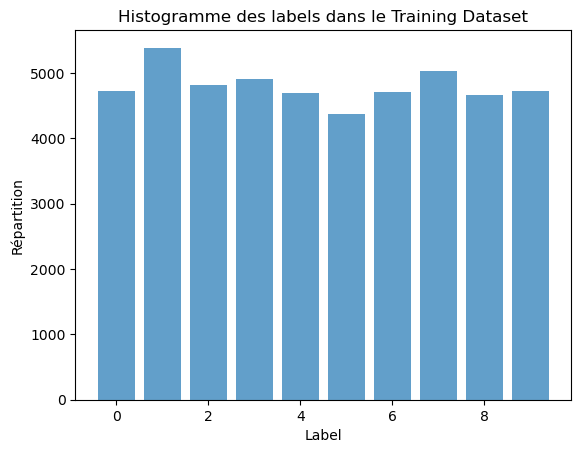

In [6]:
from collections import Counter

labels = [label for _, label in train_dataset]
label_counts = Counter(labels)
labels, counts = zip(*label_counts.items())

plt.bar(labels, counts, align='center', alpha=0.7)
plt.xlabel('Label')
plt.ylabel('Répartition')
plt.title('Histogramme des labels dans le Training Dataset')
plt.show()


The repartition of label is balanced except for the class '1' a little overrepresented and '4' which is a bit underreprensented.
The solution can be to cut some data from class 2 and add some to class 4 or cut data such that they all have as many occurences as class 4.

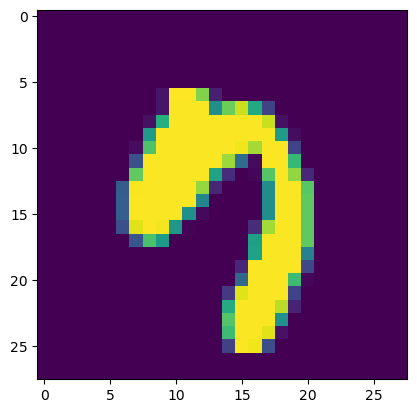

In [4]:
plt.imshow(train_dataset[0][0][0])

In [1]:
class CNN_model(torch.nn.Module):

    def __init__(self):
        super(CNN_model, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, (5, 5), stride=(1, 1))
        self.activation = torch.nn.ReLU()
        self.mp2D = torch.nn.MaxPool2d((2,2), stride=(2,2))
        self.conv2 = torch.nn.Conv2d(32, 64, (3, 3), stride=(1, 1))
        self.linear = torch.nn.Linear(64*5*5, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.activation(x)
        x = self.mp2D(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.mp2D(x)
        x=x.view(-1,64*5*5)
        x = self.linear(x)
        
        return x


NameError: name 'torch' is not defined

Softmax gives a probability for the different classes so it's perfectly adapted for our problem
Categorical cross-entropy is a better loss function for multi label classification.
Logistic function as a final layer and binary cross entropy for the loss.

In [6]:
len(train_dataset)

48000

In [7]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    nb_bonne_pred = 0
    nb_pred = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_1(inputs)
        _, predictions = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        nb_bonne_pred += (predictions == labels).sum().item()
        nb_pred += labels.size(0) 
    accuracy = nb_bonne_pred / nb_pred
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Acc: {accuracy}')


Epoch [1/10], Loss: 0.051717083901166916, Acc: 0.9216041666666667
Epoch [2/10], Loss: 0.07602542638778687, Acc: 0.97775
Epoch [3/10], Loss: 0.005653715692460537, Acc: 0.98325
Epoch [4/10], Loss: 0.07272800803184509, Acc: 0.9859791666666666
Epoch [5/10], Loss: 0.04428292065858841, Acc: 0.9882916666666667
Epoch [6/10], Loss: 0.11981061846017838, Acc: 0.9902291666666667
Epoch [7/10], Loss: 0.04992663115262985, Acc: 0.9913958333333334
Epoch [8/10], Loss: 0.03464846312999725, Acc: 0.9924166666666666
Epoch [9/10], Loss: 0.004369383677840233, Acc: 0.9932083333333334
Epoch [10/10], Loss: 0.0023268593940883875, Acc: 0.9936041666666666


In [8]:
nb_bonne_pred = 0
nb_pred = 0

model_1.eval()

with torch.no_grad(): 
    for inputs, labels in test_loader:
        outputs = model_1(inputs)
        _, predictions = torch.max(outputs, 1) 
        nb_bonne_pred += (predictions == labels).sum().item()
        nb_pred += labels.size(0) 

accuracy = nb_bonne_pred / nb_pred

print(f'Test Accuracy: {accuracy * 100:.2f}%')


Test Accuracy: 98.96%


We use the accuracy to evaluate the model

In [9]:
def fgsm_attack_l_inf(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

We generate adversarial examples :

In [3]:
criterion = torch.nn.CrossEntropyLoss()

def test_l_inf(model, test_loader, epsilon):
    correct = 0
    total = 0
    adv_examples = []

    for images, labels in test_loader:
        
        images, labels = images.cpu(), labels.cpu()
        
        images.requires_grad = True
        
        outputs = model_1(images)
        init_pred = outputs.max(1, keepdim=True)[1][1].item()
        #print(init_pred)
        loss = criterion(outputs, labels)
        
        model_1.zero_grad()
        loss.backward()
        data_grad = images.grad.data
        
        perturbed_images = fgsm_attack_l_inf(images, epsilon, data_grad) #création de data perturbée
        outputs = model_1(perturbed_images) #reclassification des images perturbées par l'attaque dans le modèle
        _, predicted = torch.max(outputs.data, 1)
        
                #for acc computation
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Check for success
        final_pred_tens = outputs.max(1, keepdim=True)[1][1]
        final_pred = outputs.max(1, keepdim=True)[1][1].item()
        
        if torch.equal(final_pred_tens, labels):
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_images.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred, final_pred, adv_ex))
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_images.squeeze().detach().cpu().numpy()[1]
                adv_examples.append((init_pred, final_pred, adv_ex))
        
    accuracy = correct / total
    print(f'Test Accuracy on Adversarial Examples: {accuracy * 100:.2f}%')
    return accuracy, adv_examples
    
#epsilon = 0.02
#test_l_inf(model_1, test_loader, epsilon)

NameError: name 'torch' is not defined

We want to see the effect of the attack

In [2]:
accuracies = []
examples = []
epsilons = [0, .05, .1, .15, .2, .25, .3]

for eps in epsilons:
    acc, ex = test_l_inf(model_1, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

NameError: name 'test_l_inf' is not defined

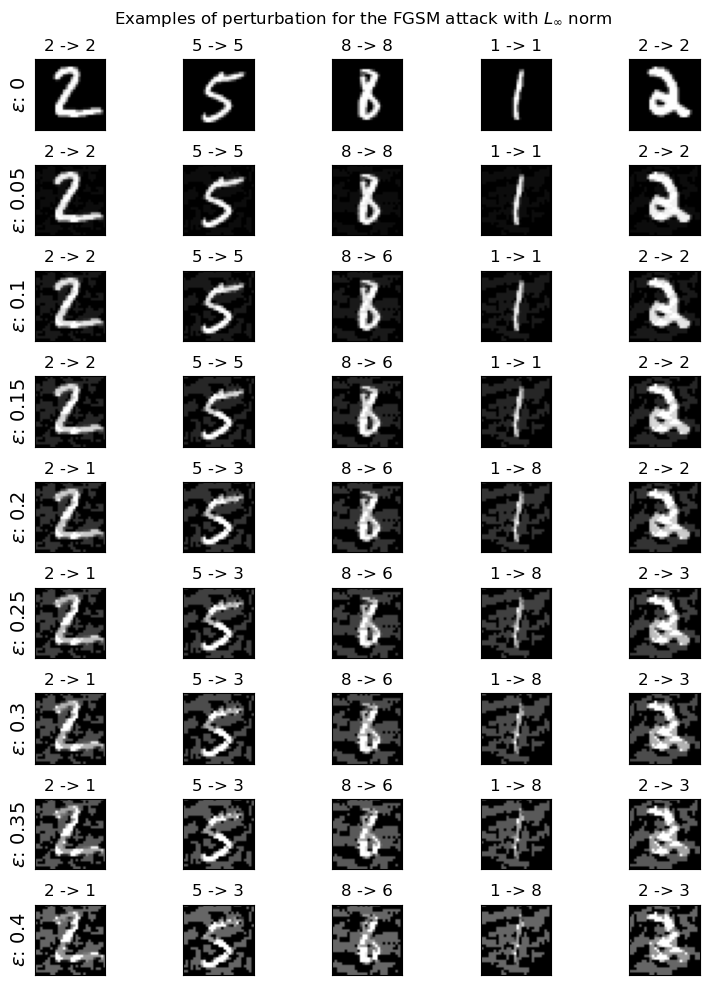

In [12]:
cnt = 0
plt.figure(figsize=(8,10))
plt.suptitle('Examples of perturbation for the FGSM attack with $L_\infty$ norm')
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"$\epsilon$: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()            
plt.show()

The $L_\infty$ norm induces a change that is limited by the epsilon value in each pixel of the perturbed image.
The perturbation is observed by patches of color that sort of blur the image. 
Nonetheless, the shape of the number is still distinct, and the numbers are badly predicted before the human eye can discern the difference between a perturbe image and a normal one so it is a good norm for this situation.

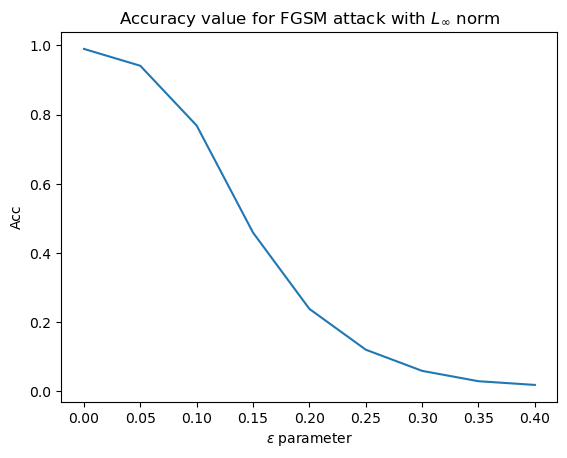

In [13]:
plt.figure()
plt.title('Accuracy value for FGSM attack with $L_\infty$ norm')
plt.xlabel('$\epsilon$ parameter')
plt.ylabel('Acc')
plt.plot(epsilons,accuracies)

The accuracy has the steepest decrease when the $\epsilon$ is close to $\frac{1}{2}$. This means that a very small alteration of the pixel is insufficient ( $\epsilon \in [0 ; 0.3]$ ) brings down the accuracy only by $\approx 20\%$. It also means that an $\epsilon$ too close to $1$ isn't cost-effective.

Same work with the $L_2$ norm

In [14]:
def fgsm_attack_l_2(image, epsilon, data_grad):
    norm_data_grad = torch.norm(data_grad, p=2, dim=(1, 2, 3), keepdim=True)
    scaled_data_grad = data_grad / norm_data_grad
    perturbed_image = image + epsilon * scaled_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [15]:
criterion = torch.nn.CrossEntropyLoss()

def test_l_2(model, test_loader, epsilon):
    correct = 0
    total = 0
    adv_examples = []

    for images, labels in test_loader:
        
        images, labels = images.cpu(), labels.cpu()
        
        images.requires_grad = True
        
        outputs = model_1(images)
        init_pred = outputs.max(1, keepdim=True)[1][1].item()
        #print(init_pred)
        loss = criterion(outputs, labels)
        
        model_1.zero_grad()
        loss.backward()
        data_grad = images.grad.data
        
        perturbed_images = fgsm_attack_l_2(images, epsilon, data_grad) #création de data perturbée
        outputs = model_1(perturbed_images) #reclassification des images perturbées par l'attaque dans le modèle
        _, predicted = torch.max(outputs.data, 1)
        
                #for acc computation
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Check for success
        final_pred_tens = outputs.max(1, keepdim=True)[1][1]
        final_pred = outputs.max(1, keepdim=True)[1][1].item()
        
        if torch.equal(final_pred_tens, labels):
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_images.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred, final_pred, adv_ex))
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_images.squeeze().detach().cpu().numpy()[1]
                adv_examples.append((init_pred, final_pred, adv_ex))
        
    accuracy = correct / total
    print(f'Test Accuracy on Adversarial Examples: {accuracy * 100:.2f}%')
    return accuracy, adv_examples
    
#epsilon = 0.02
#test_l_2(model_1, test_loader, epsilon)

In [16]:
accuracies = []
examples = []
epsilons = [0, 1.5, 3, 4.5, 6, 7.5, 9, 10.5, 12]

for eps in epsilons:
    acc, ex = test_l_2(model_1, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Test Accuracy on Adversarial Examples: 98.96%
Test Accuracy on Adversarial Examples: 76.71%
Test Accuracy on Adversarial Examples: 25.29%
Test Accuracy on Adversarial Examples: 11.57%
Test Accuracy on Adversarial Examples: 6.87%
Test Accuracy on Adversarial Examples: 5.10%
Test Accuracy on Adversarial Examples: 4.31%
Test Accuracy on Adversarial Examples: 3.95%
Test Accuracy on Adversarial Examples: 3.66%


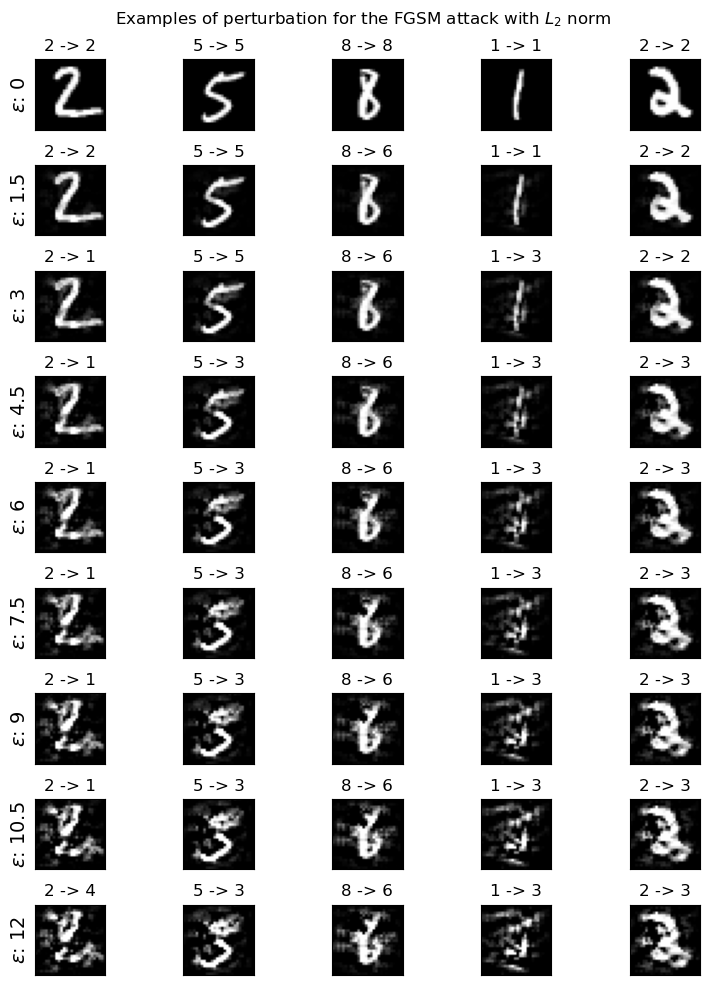

In [17]:
cnt = 0
plt.figure(figsize=(8,10))
plt.suptitle('Examples of perturbation for the FGSM attack with $L_2$ norm')
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"$\epsilon$: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
        plt.subplots_adjust(top=0.9)
plt.tight_layout()            
plt.show()

The $L_2$ norm perturbs more uniformly the pixels, this visually translates by the numbers becoming unreadable as the epsilon value augments.

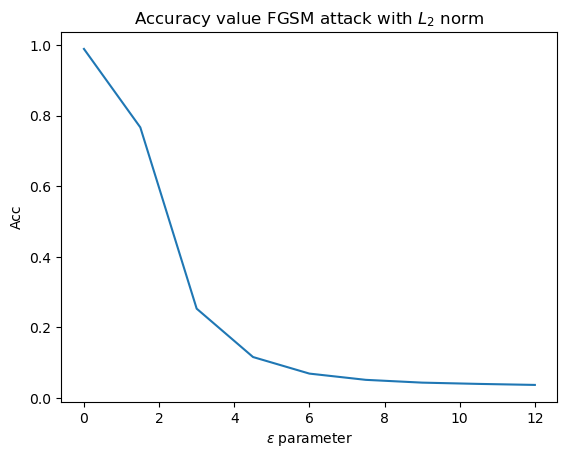

In [18]:
plt.figure()
plt.title('Accuracy value FGSM attack with $L_2$ norm')
plt.xlabel('$\epsilon$ parameter')
plt.ylabel('Acc')
plt.plot(epsilons,accuracies)

The accuracy drops rapidly from very low values of the epsilon parameter, for an $\epsilon$ higher than 3 we have already a very low accuracy.

$\textbf{Global conclusion :}$ We observe a more convincing result with the $L_\infty$ norm because the human eyes see the right number no matter the degree of perturbation whereas with the other norm, the shape is altered and it isn't a missleading data it just becomes invalid data. This means it could be eliminated before being missclassified either by the data collector or by a preprocess supressing the outliers.

$\textbf{BIM Attacks}$

In [19]:
criterion = torch.nn.CrossEntropyLoss()

def bim_attack_l_inf(model, image, label, epsilon, alpha, num_iterations):
    perturbed_image = torch.tensor(image.clone().detach(), requires_grad=True)
    
    for _ in range(num_iterations):
        # Clone perturbed_image to create a new leaf variable
        perturbed_image = perturbed_image.clone().detach().requires_grad_(True)
        outputs = model(perturbed_image)
        loss = criterion(outputs, label)
        model.zero_grad()
        loss.backward()
        data_grad = perturbed_image.grad.data

        # Normalization
        norm_data_grad = torch.norm(data_grad, p=2, dim=(1, 2, 3), keepdim=True)
        scaled_data_grad = data_grad / (norm_data_grad + 1e-10)

        #We  update perturbed image
        perturbed_image = perturbed_image + alpha * scaled_data_grad
        perturbed_image = torch.clamp(perturbed_image, 0, 1)

        #We stay in the epsilon ball using clip
        perturbation = perturbed_image - image
        norm_perturbation = torch.norm(perturbation, p=2, dim=(1, 2, 3), keepdim=True)
        perturbation = perturbation * epsilon / (norm_perturbation + 1e-10)
        perturbed_image = image + perturbation
        perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image


In [20]:
criterion = torch.nn.CrossEntropyLoss()

def test_l_inf(model, test_loader, epsilon, alpha, num_iterations):
    correct = 0
    total = 0
    adv_examples = []

    for images, labels in test_loader:
        
        images, labels = images.cpu(), labels.cpu()
        
        images.requires_grad = True
        
        outputs = model_1(images)
        init_pred = outputs.max(1, keepdim=True)[1][1].item()
        #print(init_pred)
        loss = criterion(outputs, labels)
        
        model_1.zero_grad()
        loss.backward()
        data_grad = images.grad.data
        perturbed_images = bim_attack_l_inf(model, images, labels, epsilon, alpha, num_iterations)

        outputs = model_1(perturbed_images) #reclassification des images perturbées par l'attaque dans le modèle
        _, predicted = torch.max(outputs.data, 1)
        
                #for acc computation
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Check for success
        final_pred_tens = outputs.max(1, keepdim=True)[1][1]
        final_pred = outputs.max(1, keepdim=True)[1][1].item()
        
        if torch.equal(final_pred_tens, labels):
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_images.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred, final_pred, adv_ex))
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_images.squeeze().detach().cpu().numpy()[1]
                adv_examples.append((init_pred, final_pred, adv_ex))
        
    accuracy = correct / total
    print(f'Test Accuracy on Adversarial Examples: {accuracy * 100:.2f}%')
    return accuracy, adv_examples
    
#epsilon = 0.02
#alpha = 0.01
#num_iterations = 10
#test_l_inf(model_1, test_loader, epsilon, alpha, num_iterations)

My computer started being very slow for BIM computations so it will have less examples

In [21]:
accuracies_e = []
examples_e = []
epsilons = [0, 1, 2, 3, 4]
alpha = 0.01
num_iterations = 10
for eps in epsilons:
    acc, ex = test_l_inf(model_1, test_loader, eps, alpha, num_iterations)
    accuracies_e.append(acc)
    examples_e.append(ex)

C:\Users\benmo\AppData\Local\Temp\ipykernel_25816\3009725202.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  perturbed_image = torch.tensor(image.clone().detach(), requires_grad=True)


Test Accuracy on Adversarial Examples: 98.96%
Test Accuracy on Adversarial Examples: 85.20%
Test Accuracy on Adversarial Examples: 41.21%
Test Accuracy on Adversarial Examples: 15.16%
Test Accuracy on Adversarial Examples: 7.22%


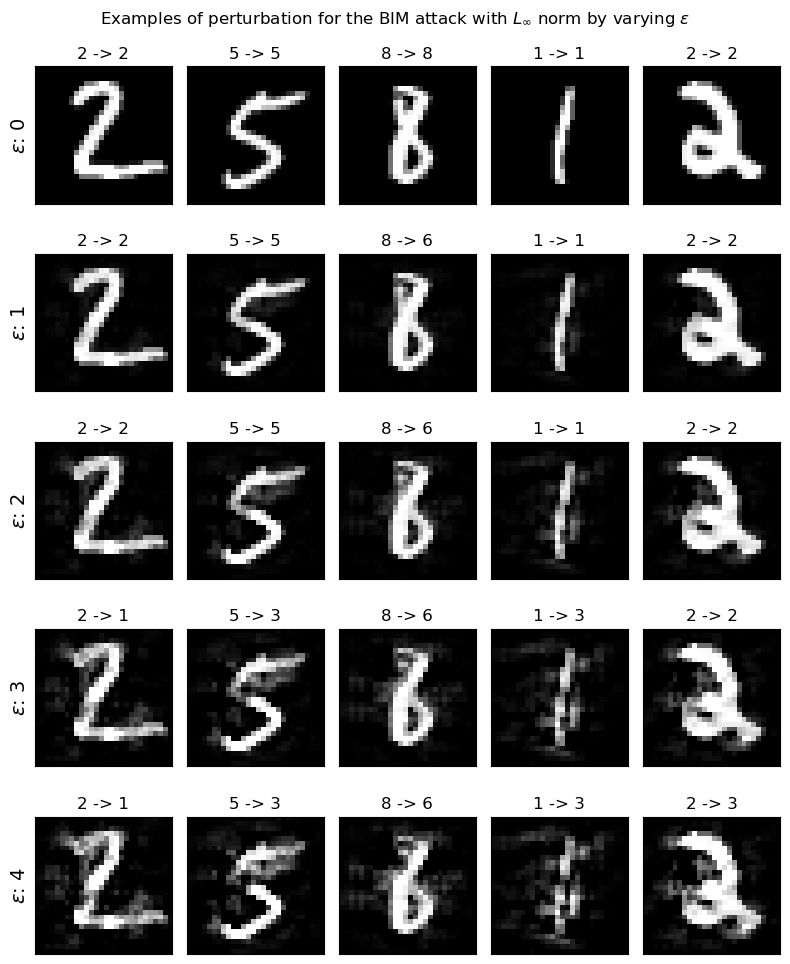

In [22]:
cnt = 0
plt.figure(figsize=(8,10))
plt.suptitle('Examples of perturbation for the BIM attack with $L_\infty$ norm by varying $\epsilon$')
for i in range(len(epsilons)):
    for j in range(len(examples_e[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples_e[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"$\epsilon$: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples_e[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()            
plt.show()

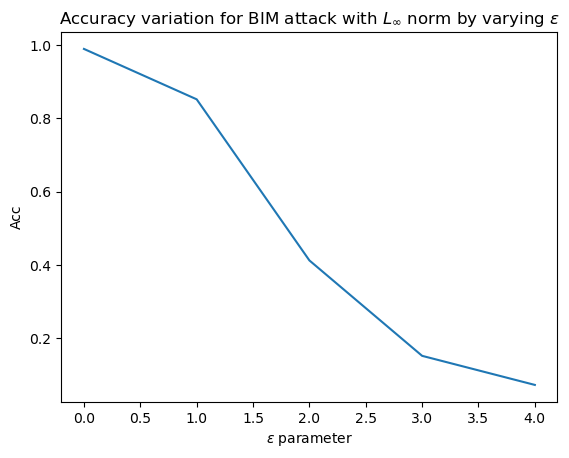

In [23]:
plt.figure()
plt.title('Accuracy variation for BIM attack with $L_\infty$ norm by varying $\epsilon$')
plt.xlabel('$\epsilon$ parameter')
plt.ylabel('Acc')
plt.plot(epsilons,accuracies_e)

In [24]:
accuracies_a = []
examples_a = []
alphas = [0, 0.2, 0.4, 0.6, 0.8]
epsilon = 2
for alp in alphas:
    acc, ex = test_l_inf(model_1, test_loader, epsilon, alp, num_iterations)
    accuracies_a.append(acc)
    examples_a.append(ex)

C:\Users\benmo\AppData\Local\Temp\ipykernel_25816\3009725202.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  perturbed_image = torch.tensor(image.clone().detach(), requires_grad=True)


Test Accuracy on Adversarial Examples: 98.96%
Test Accuracy on Adversarial Examples: 17.18%
Test Accuracy on Adversarial Examples: 13.32%
Test Accuracy on Adversarial Examples: 12.26%
Test Accuracy on Adversarial Examples: 11.92%


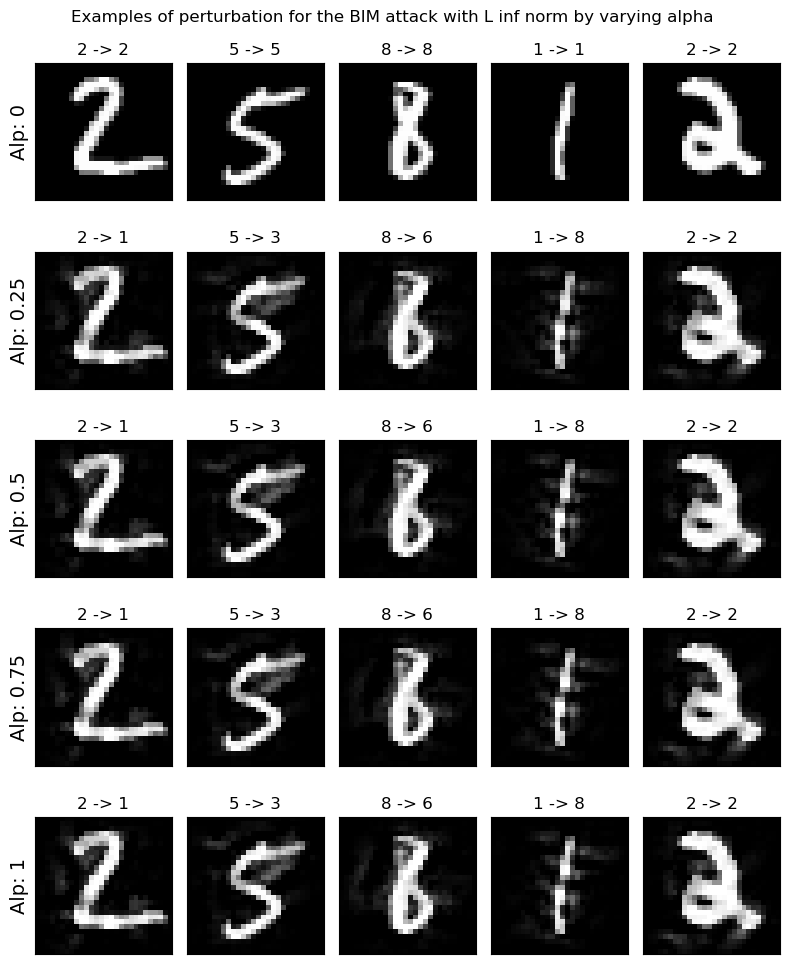

In [25]:
cnt = 0
plt.figure(figsize=(8,10))
plt.suptitle('Examples of perturbation for the BIM attack with L inf norm by varying alpha ')
for i in range(len(alphas)):
    for j in range(len(examples_a[i])):
        cnt += 1
        plt.subplot(len(alphas),len(examples_a[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Alp: {alphas[i]}", fontsize=14)
        orig,adv,ex = examples_a[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()            
plt.show()

In [ ]:
plt.figure()
plt.title('Accuracy variation for BIM attack with L inf norm by varying alpha ')
plt.xlabel('alpha parameter')
plt.ylabel('Acc')
plt.plot(epsilons,accuracies_e)

We now work with the $L_2$ norm

In [27]:
def fgsm_attack_l_2(image, epsilon, data_grad):
    norm_data_grad = torch.norm(data_grad, p=2, dim=(1, 2, 3), keepdim=True)
    scaled_data_grad = data_grad / norm_data_grad
    perturbed_image = image + epsilon * scaled_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [28]:
criterion = torch.nn.CrossEntropyLoss()

def test_l_2(model, test_loader, epsilon):
    correct = 0
    total = 0
    adv_examples = []

    for images, labels in test_loader:
        
        images, labels = images.cpu(), labels.cpu()
        
        images.requires_grad = True
        
        outputs = model_1(images)
        init_pred = outputs.max(1, keepdim=True)[1][1].item()
        #print(init_pred)
        loss = criterion(outputs, labels)
        
        model_1.zero_grad()
        loss.backward()
        data_grad = images.grad.data
        
        perturbed_images = fgsm_attack_l_2(images, epsilon, data_grad) #création de data perturbée
        outputs = model_1(perturbed_images) #reclassification des images perturbées par l'attaque dans le modèle
        _, predicted = torch.max(outputs.data, 1)
        
                #for acc computation
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Check for success
        final_pred_tens = outputs.max(1, keepdim=True)[1][1]
        final_pred = outputs.max(1, keepdim=True)[1][1].item()
        
        if torch.equal(final_pred_tens, labels):
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_images.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred, final_pred, adv_ex))
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_images.squeeze().detach().cpu().numpy()[1]
                adv_examples.append((init_pred, final_pred, adv_ex))
        
    accuracy = correct / total
    print(f'Test Accuracy on Adversarial Examples: {accuracy * 100:.2f}%')
    return accuracy, adv_examples
    
#epsilon = 0.02
#test_l_2(model_1, test_loader, epsilon)

In [29]:
import torch
import torch.nn.functional as F

criterion = torch.nn.CrossEntropyLoss()

def bim_attack_l_2(model, image, label, epsilon, alpha, num_iterations):
    perturbed_image = torch.tensor(image.clone().detach(), requires_grad=True)
    
    for _ in range(num_iterations):
        # Clone perturbed_image to create a new leaf variable
        perturbed_image = perturbed_image.clone().detach().requires_grad_(True)
        outputs = model(perturbed_image)
        loss = criterion(outputs, label)
        model.zero_grad()
        loss.backward()
        data_grad = perturbed_image.grad.data

        # Normalization
        norm_data_grad = torch.norm(data_grad, p=2, dim=(1, 2, 3), keepdim=True)
        scaled_data_grad = data_grad / (norm_data_grad + 1e-10)

        # Update perturbed image with L2 norm constraint
        perturbed_image = perturbed_image + alpha * scaled_data_grad
        perturbation = perturbed_image - image
        norm_perturbation = torch.norm(perturbation, p=2, dim=(1, 2, 3), keepdim=True)
        perturbation = perturbation * epsilon / (norm_perturbation + 1e-10)
        perturbed_image = image + perturbation
        perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image


In [30]:
criterion = torch.nn.CrossEntropyLoss()

def test_l_2(model, test_loader, epsilon, alpha, num_iterations):
    correct = 0
    total = 0
    adv_examples = []

    for images, labels in test_loader:
        
        images, labels = images.cpu(), labels.cpu()
        
        images.requires_grad = True
        
        outputs = model_1(images)
        init_pred = outputs.max(1, keepdim=True)[1][1].item()
        #print(init_pred)
        loss = criterion(outputs, labels)
        
        model_1.zero_grad()
        loss.backward()
        data_grad = images.grad.data
        perturbed_images = bim_attack_l_2(model, images, labels, epsilon, alpha, num_iterations)

        outputs = model_1(perturbed_images) #reclassification des images perturbées par l'attaque dans le modèle
        _, predicted = torch.max(outputs.data, 1)
        
                #for acc computation
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Check for success
        final_pred_tens = outputs.max(1, keepdim=True)[1][1]
        final_pred = outputs.max(1, keepdim=True)[1][1].item()
        
        if torch.equal(final_pred_tens, labels):
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_images.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred, final_pred, adv_ex))
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_images.squeeze().detach().cpu().numpy()[1]
                adv_examples.append((init_pred, final_pred, adv_ex))
        
    accuracy = correct / total
    print(f'Test Accuracy on Adversarial Examples: {accuracy * 100:.2f}%')
    return accuracy, adv_examples
    
#epsilon = 0.02
#alpha = 0.01
#num_iterations = 10
#test_l_2(model_1, test_loader, epsilon, alpha, num_iterations)

In [31]:
accuracies_e = []
examples_e = []
epsilons = [0, 1, 2, 3, 4]
alpha = 0.01
num_iterations = 10
for eps in epsilons:
    acc, ex = test_l_2(model_1, test_loader, eps, alpha, num_iterations)
    accuracies_e.append(acc)
    examples_e.append(ex)

C:\Users\benmo\AppData\Local\Temp\ipykernel_25816\1425461252.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  perturbed_image = torch.tensor(image.clone().detach(), requires_grad=True)


Test Accuracy on Adversarial Examples: 98.96%
Test Accuracy on Adversarial Examples: 85.20%
Test Accuracy on Adversarial Examples: 41.21%
Test Accuracy on Adversarial Examples: 15.14%
Test Accuracy on Adversarial Examples: 7.22%


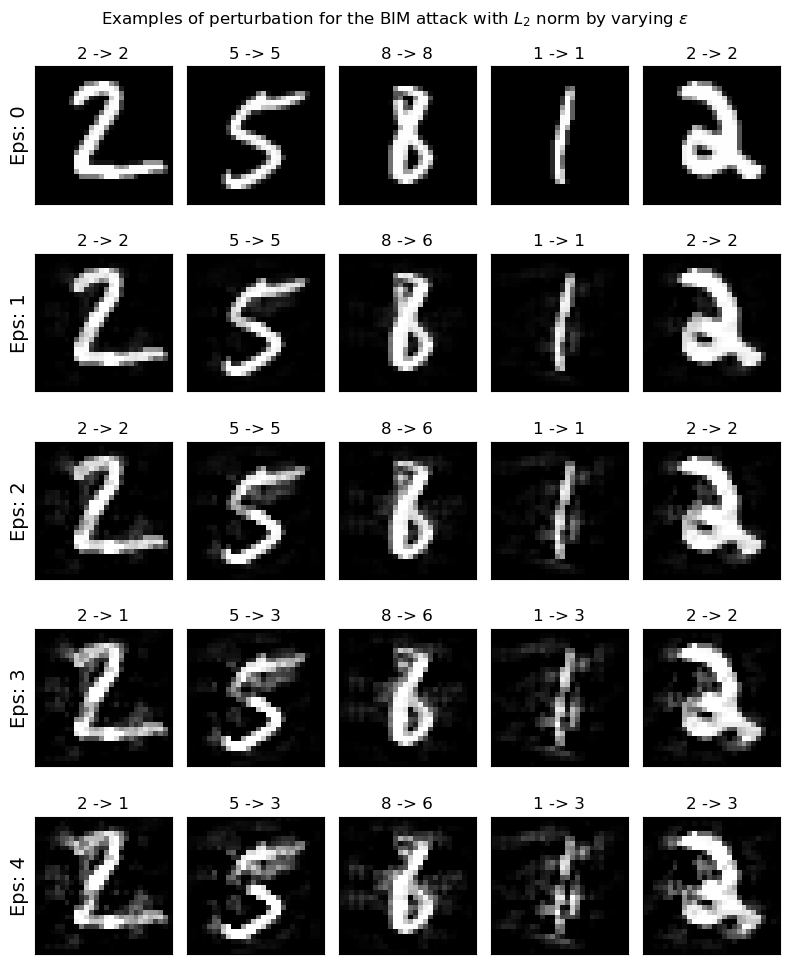

In [32]:
cnt = 0
plt.figure(figsize=(8,10))
plt.suptitle('Examples of perturbation for the BIM attack with $L_2$ norm by varying $\epsilon$')
for i in range(len(epsilons)):
    for j in range(len(examples_e[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples_e[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples_e[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()            
plt.show()

The $L_\infty$ norm induces a change that is limited by the epsilon value in each pixel of the perturbed image.
The perturbation is observed by patches of color that sort of blur the image. 
Nonetheless, the shape of the number is still distinct, and the numbers are badly predicted before the human eye can discern the difference between a perturbe image and a normal one so it is a good norm for this situation.

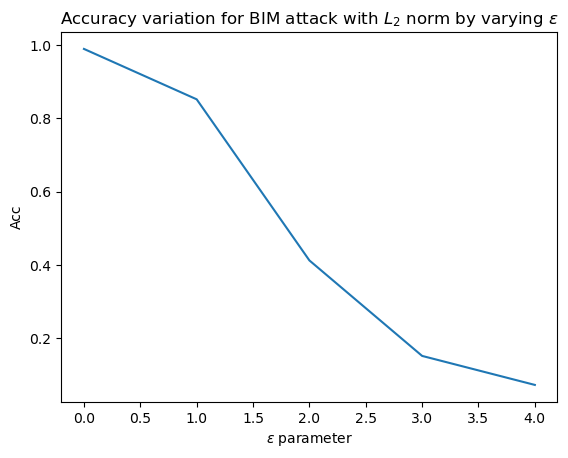

In [33]:
plt.figure()
plt.title('Accuracy variation for BIM attack with $L_2$ norm by varying $\epsilon$')
plt.xlabel('$\epsilon$ parameter')
plt.ylabel('Acc')
plt.plot(epsilons,accuracies_e)

In [36]:
accuracies_a = []
examples_a = []
alphas = [0, 1, 2, 3, 4]
epsilon = 4
for alp in alphas:
    acc, ex = test_l_inf(model_1, test_loader, epsilon, alp, num_iterations)
    accuracies_a.append(acc)
    examples_a.append(ex)

C:\Users\benmo\AppData\Local\Temp\ipykernel_25816\3009725202.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  perturbed_image = torch.tensor(image.clone().detach(), requires_grad=True)


KeyboardInterrupt: 

In [ ]:
cnt = 0
plt.figure(figsize=(8,10))
plt.suptitle('Examples of perturbation for the BIM attack with $L_2$ norm by varying $\alphas$')
for i in range(len(alphas)):
    for j in range(len(examples_a[i])):
        cnt += 1
        plt.subplot(len(alphas),len(examples_a[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Alp: {alphas[i]}", fontsize=14)
        orig,adv,ex = examples_a[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()            
plt.show()

The $L_\infty$ norm induces a change that is limited by the epsilon value in each pixel of the perturbed image.
The perturbation is observed by patches of color that sort of blur the image. 
Nonetheless, the shape of the number is still distinct, and the numbers are badly predicted before the human eye can discern the difference between a perturbe image and a normal one so it is a good norm for this situation.

In [ ]:
plt.figure()
plt.title('Accuracy variation for BIM attack with $L_2$ norm by varying $\alpha$')
plt.xlabel('$\epsilon$ parameter')
plt.ylabel('Acc')
plt.plot(epsilons,accuracies_e)

Adversarial training

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


def adversarial_train(model, train_loader, epsilon, alpha, num_iterations, pixel_value_range):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()

        for images, labels in train_loader:
            images, labels = images.cuda(), labels.cuda()
            images.requires_grad = True

            # Generate adversarial examples using BIM attack
            perturbed_images = bim_attack_l_inf(model, images, labels, epsilon, alpha, num_iterations)

            
            outputs = model(perturbed_images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return model

epsilon = 0.3  
alpha = 0.01
num_iterations = 40
num_epochs = 5  

reinforced_model = adversarial_train(model_1, train_loader, epsilon, alpha, num_iterations, pixel_value_range)